<a href="https://colab.research.google.com/github/raqueldias/ALS3200C/blob/main/nonlinear_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nonlinear neural network models

A step-by-step walthrough video on this exercise is available [here](https://youtu.be/MGDz1v1vTzg).

Linear models are good and all, but the real *power* of neural networks is in their capacity to approximate nearly *any* nonlinear function.

The original mathematical proof of the "universal approximation theorem" for neural networks is, unfortunately, behind a pay-wall, but a copy of the paper is [here](https://github.com/bryankolaczkowski/ALS3200C/blob/main/hornik1989.pdf). The main conclusion of the paper is: "standard multilayer feed-forward network architectures using arbitrary [activation] functions can approximate virtually any function of interest to any desired degree of accuracy, provided sufficiently many hidden units are available."

So, to approximate (nearly) *any* arbitrary nonlinear function, all we need is:

* a neural network with some non-linear activation function
* "sufficiently many hidden units"

So, what's a "hidden unit"?

In neural networks, there are two layers that are 'exposed' to the outside world: the *input* layer and the *output* layer. All *other* layers in the network are called "hidden", because we can't 'see' them, directly.

The figure below shows a general 'feed-forward' neural network with two "hidden" layers (yellow), in addition to an input layer (red) and an output layer (teal). The input data and output response is shown in gray.

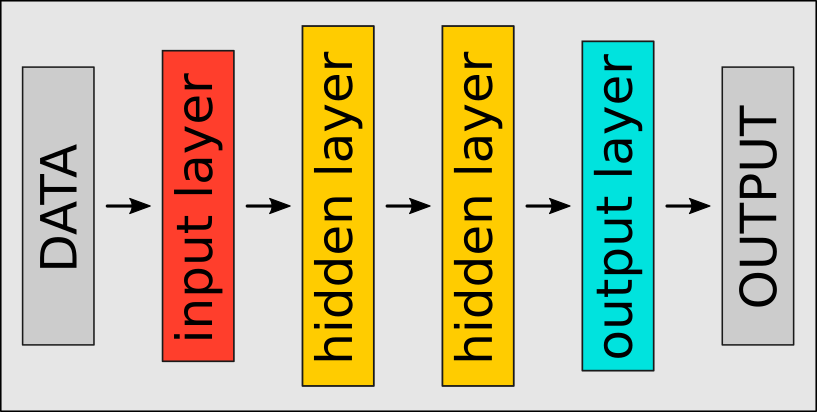

A *linear* neural network has a single layer, which is *both* the input *and* the output layer, so a linear model has *no* hidden layers and isn't a universal function approximator (good thing, too, it's *supposed* to be linear!).

The following figure shows a schematic of a general 'linear' neural network, with a single input/output layer.

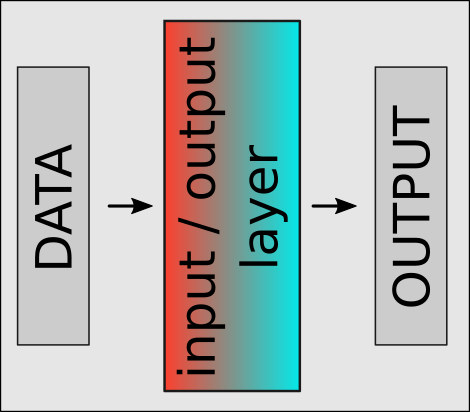

Similarly, a neural network with two layers has an input and an output layer, but *no hidden layers*, so it doesn't fit the criteria for universal approximation. This is shown in the figure below.

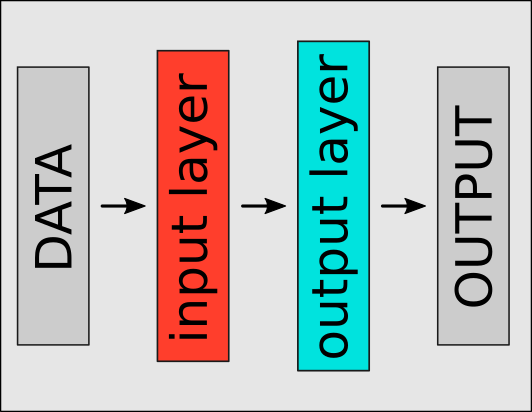

So, to approximate an arbitrary nonlinear function, we need a neural network with *at least* three layers: an input layer, an output layer and at least one "hidden" layer, inbetween.

We *also* need to use non-linear activations between the layers, or else our model will 'collapse' into a simple linear model! At a *minimum*, we'd need non-linear activations after the input layer and after *each* of the hidden layers in the network; we can leave the output layer with linear activation, if we'd like.

The following figure shows a neural network with three layers, including the input (red), output (teal) and a single hidden (yellow) layer. Non-linear activations (green) have been applied to the input layer and the hidden layer. The output layer does not have a non-linear activation, in this case.

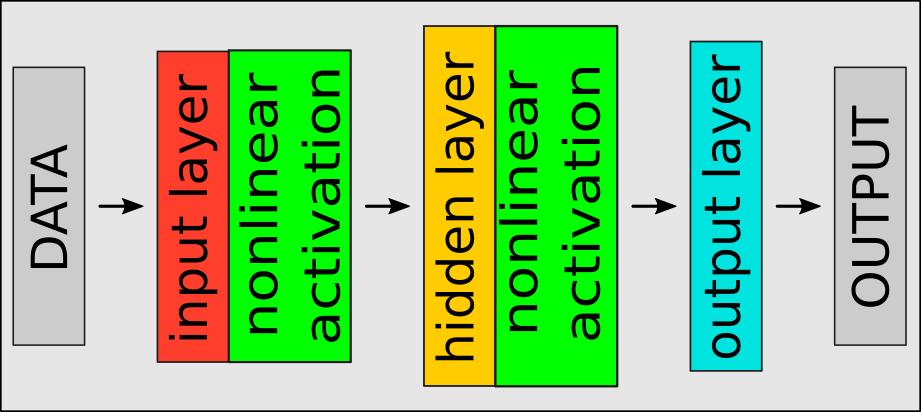


The simple network in the figure above is a *candidate* for universal function approximation, privided "sufficiently many hidden units are available".

How do we know when we have "sufficiently many hidden units"?

In practice, we don't.

Unfortunately, like many mathematical proofs, the universal function approximation theorem for neural networks only tells us that, given an arbitrary function we'd like to approximate to a specified level of accuracy, there *exists* a feed-forward neural network that *can* approximate that function, to our desired level of accuracy. The theorem does *not* offer much guidance as to how to *construct* the neural network!

*Except*, we know that we'll need to use nonlinear activations (any nonlinear activation function should do), and we are likely going to need more than one neuron (aka, "unit") in the hidden layer (we might also want to use more than one hidden layer).

## fitting a neural network to nonlinear data

With that guidance from the mathematicians, let's start building some nonlinear neural networks!

While we don't actually *need* any data to build a neural network, we *will* need some nonlinear data to *fit* our nonlinear neural-network model and *examine* the reliability of the model fit.

So, first we need to simulate some data according to a nonlinear model.

For now, we'll just simulate some very simple polynomial data in one dimension. While polynomials are pretty *simple* nonlinear functions, they are widely used as models to study nonlinear model fitting, and they can actually be a bit tricky to model using neural networks.

One of the 'simplest' nonlinear polynomials is the degree-2 polynomial

    y = m * x**2 + b

which looks like a linear model, except we are "squaring" the explanatory variable, x. Here, "x**2" just means 'raise x to the power 2'.

We can use scikit-learn's "make_regression" function (with a little transformation) to simulate training data from our simple degree-2 polynomial, wich has the characterisic "U"-shape.

In [ ]:
import sklearn.datasets
import matplotlib.pyplot as plt

x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=0.0,
                                       noise=10.0,
                                       random_state=102218)
# transform linear data to polynomial
y = (y/200.0)**2 - 0.5

plt.scatter(x,y, marker='o')

The training data looks pretty 'polynomial'.

Let's start by just fitting a simple linear model to these data, to see how 'good' we can get it. We'll use the exact same tensorflow code as before.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Looking at the plot shows us that the linear model is a *very* poor fit for this data. The residuals show significant 'trends' throughout the range of x-values (they are highly positive at the ends, and negative in the middle!), and they are often very 'large' (in absolute value).

We expect this linear model to be a poor fit to our polynomial data, but it was worth it to check.

Let's fix this problem by making our neural network model nonlinear!

We'll start by building a *very* simple nonlinear model with only two network layers (ie, *no* hidden layers, just input and output layers). While this simple nonlinear network is *not* guaranteed to be a 'universal function approximator', we don't necessarily need our neural network to be 'universal' in this case; we just need it to approximate a simple polynomial.

Remember that, if we don't include a nonlinear activation function after the input layer, we *won't* have a nonlinear model; the network will 'collapse' to a simple linear model.

Let's start by just building a 2-layer neural network, with 1 neuron ("unit") per layer. We'll ignore nonlinear activations for now.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

As the model summary shows, this model has two layers (network "depth" is 2). Each layer consists of a single densely-connected neuron unit (layer "width" is 1). There are 2 "trainable" parameters in each layer (the slope and bias of the linear model), for a total of 4 trainable parameters in the model.

Without nonlinear activations, this 2-layer model will 'collapse' into a simple linear model, which we can confirm by fitting it to our polynomial data.

In [ ]:
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

The final loss value of the fitted model (0.0358 in my case) is almost *exactly* the same as the single-layer linear model's mean-squared error loss (which was 0.0359 for me), and the plot of the predicted y_hat values (orange +) *appears* very linear.

To make our model nonlinear, we need to add a nonlinear activation to the first layer (input layer) of the model.

There are a few ways to do this in tensorflow. The *easiest* for now is to just set the "activation" option when the layer object is created. This can be done by setting the option:

    activation=ACTIVATION_SPECIFIER

when creating the first layer in the network.

So, what does an "ACTIVATION_SPECIFIER" look like?

The "ACTIVATION_SPECIFIER" (which I made up; it isn't a 'real' thing) tells tensorflow which activation function you'd like to use after the layer's output. The built-in activation functions in tensorflow can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations). They are located in the "tf.keras.activations" sub-module and have names like "sigmoid" (sigmoid activation), "tanh" (hyperbolic tangent activation), and "relu" (ReLU activation fucntion).

In our case, we'll use the ReLU activation function, which is implemented in tensorflow as:

    tf.keras.activations.relu

So, we can just set:

    activation=tf.keras.activations.relu

when we create the first layer of our neural network, and that layer will get ReLU nonlinear activation.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Notice that the number of "trainable" parameters in the model has *not* changed!

Nonlinear activations alter the way the model maps inputs to outputs, but they don't change the 'complexity' of the model, which is a good way to 'get' nonlinearity 'for free' (statistically).

Let's fit this simple nonlinear model, and see how it does.

In [ ]:
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

When I fit the model to our training data, the model *did* appear to fit the data *a little better* than the simple linear model. The mean-squared error loss was 0.0128, which was *lower* than the linear model's loss of 0.0359.

But, the plot of the model fit suggests that this network is *not* very good at approximating a polynomial. This model is basically a 'piecewise linear' model. In my case, the left 'half' of the polynomial appears to be approximated by a line with negative slope, and the right 'half' of the polynomial is being approximated by a horizontal line. You might also get the 'opposite': the left 'half' of the polynomial is approximated with a horizontal line, and the right 'half' is approximated by a line with positive slope.

Perhaps we can do a little better by adding a "hidden" layer to our network (with ReLU nonlinear activation):

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Now we're up to 6 trainable parameters in the model. The model's "depth" is 3 (there are 3 layers), and the layer "width" is still 1 for all layers (1 unit/layer).

Let's fit it.

In [ ]:
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Well, that didn't seem to help very much.

Perhaps we just don't have "sufficiently many hidden units" in our model? Let's try increasing the width of the "hidden" layer to 10 units, to see if that helps.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

The mean-squared error loss might be low, but the residual's don't look too good in the plot.

Are *more* hidden units the answer?

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=1000, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Doesn't look too promising. Even with 1000 hidden units, our 3-layer model is not fitting the polynomial very well. And if you scroll up, you can see from the model summary that our neural network has over 3000 trainable parameters!

Clearly, throwing more "units" at the problem is not helping us!

Let's take a step back and think about what our basic 3-layer neural network is actually doing.

## analysis of the 3-layer dense network

Our very simple neural network consisting of 3 layers, each of witdth 1, can be drawn like the following figure.

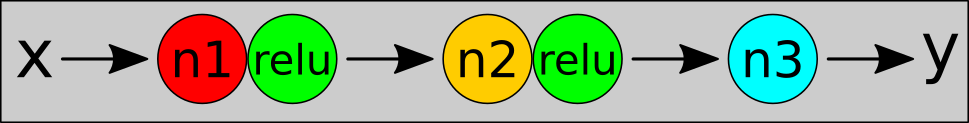

The data "x" goes into the input layer of our network (red "n1"). It is linearly-transformed by n1, and then ReLU nonlinear activation (green) is applied.

The results of n1 (after activation) go into the "hidden" layer neuron n2 (yellow), which applies a *second* linear transformation, followed by ReLU activation (green).

Finally, the results of n2 (after activation) go into the output layer neuron n3, which applies a *third* linear transformation (with *no* activation, also often called "linear activation") to produce the model's output or predicted response, "y".

So, a "forward pass" through our feed-forward neural network can be seen as a 'sequence' of linear tranforms, with non-linear transformations inbetween. Our network only has width 1 for *all* layers, so there is only *one* path through our network. But, in general, *any* individual path through *any* feed-forward neural network is a "sequence" of linear transformations, with nonlinear transformations inbetween. The output of the *entire* neural network is just the combination of the outputs of *all possible sequential paths* through the network. Of course, the *calculation* of the output is not done this way (for efficiency), but they are basically the same.

We increased the width of the hidden layer to a *large* value, which added a *lot* of parameters to our model, but didn't really improve model fit.

Let's see what increasing layer width did to our network:

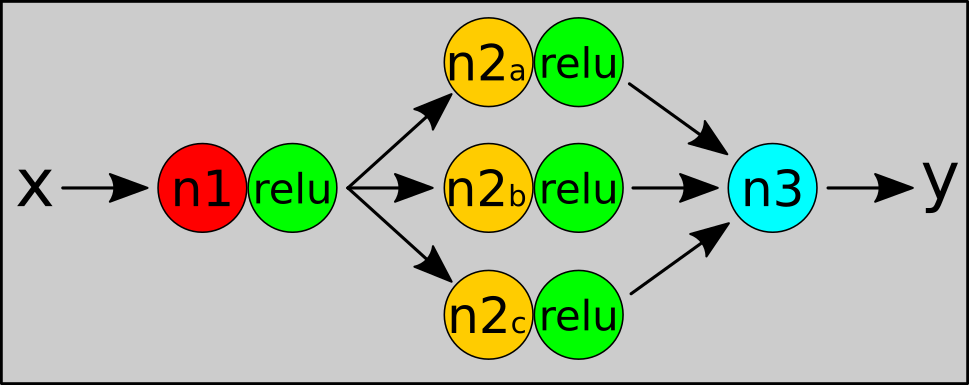

In this case, we are showing the same 3-layer network, but the width of the "hidden" layer has been increased to 3 'units' (orange n2a, n2b and n2c).

Each of the hidden units gets the output of the input-layer neuron (n1, after nonlinear activation), performs an independent linear transformation + nonlinear activation, and the results of *all three* outputs from the hidden layer are combined by the output neuron (teal  n3), which performs a linear transformation to produce "y".

It's interesting to notice that the "dimension" of n3 is now 3, whereas the dimension of *all* the other units is 1 (given that the input data "x" has dimension 1, which it does in this case).

By increasing the width of the hidden layer to 3, we have effectively 'projected' out 1-dimensional data into 3 dimensions (ie, the width of the layer). In fact, we have 'linearly projected' the input data into a space of dimension equal to the width of the layer (3, in this case). The "relu" neurons apply a nonlinear transformation of this high-dimensional data point *after* projection into the high-dimensional space.

The n3 output neuron then performs a 'linear projection' of the 3-dimensional data point *back* into 1 dimension, to response "y".

In general, we can *increase* the width of our network to 'project' the data *up* into *higher* dimensional 'space', and we can *decrease* the width of the network to 'project' the data *down* into *lower* dimensional 'space'. The projections, themselves, are 'essentially linear' (linear projection, followed by nonlinear activation).

In our case, projecting our data into 1000-dimensional space, and then *immediately* projecting it back down (after ReLU activation) didn't improve our model's capacity to model a polynomial.

## What about increasing the model's "depth"?

We could have chosen to increase the number of hidden units by adding many 1-unit hidden layers, rather than increasing the width of the single hidden layer.

That approach would generate a model that looks like this:

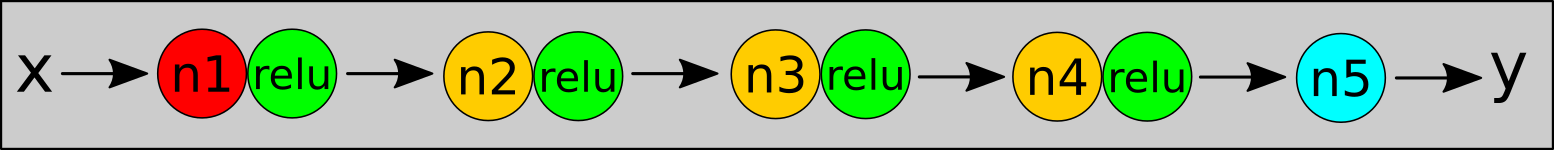

Increasing the network's "depth" creates a "deep learning" model (ha ha!).

In this case, the "width" of the layers stays the *same*, so there are *no* projections into or out of higher-dimensional or lower-dimensional spaces.

We just have a *longer sequence* of linear data transformations, with nonlinear activations inbetween.

Lets try that and see if it helps our model fit a polynomial.

In the following code cell, we introduce a python "for" loop to build a model with 100 hidden layers. The

    range(100)

function call creates a python list with 100 elements in it, and the

    for i in ...:

syntax 'loops over' the elements of the list, each time creating a *new* Dense layer object with a single unit and relu activation, and adding that layer to the model.

So, when the "for loop" 'terminates', we have a model with 100 hidden layers. You don't need to know about python for loops; most of the time neural networks are hard-coded to have a specific number of layers, but the for loop can be useful for shortening repetitive tasks. It also allows you to set network depth to be user-selectable at run-time.

But for-loops aside, you can confirm the depth of the network when you build it.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu, input_shape=[1]))
for i in range(100):
  model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

The 'deep neural network' has 204 trainable parameters. I didn't count, but there appear to be *around* 100 hidden layers.

But does 'deep learning' help our model fit a polynomial?


In [ ]:
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Doesn't appear to, in this case.

So, that's a 'bummer'. We have 2 primary ways to increase the complexity of our neural network:

* increasing the network's depth
* increasing the network's width

Neither of them, in isolation, appears to 'help' our network model this particular nonlinear function.

## increasing network width and depth

What if we tried *both* increasing the *dimension* of the model by projecting the data into a higher-dimensional space *and* applying a *longer sequence* of transformations *in that higher-dimensional space*?

By increasing the *width* of the network, we can project our data into higher-dimensional space; increasing the *depth* at the *same time* allows the network to 'do a bit of work' in that higher-dimensional space, before projecting the result back down to the required output dimension.

Mathematically, the network is applying some sequence of linear transformations with intervening nonlinear transforms *in the higher-dimensional space*.

The easiest *incremental* way to increase both depth and width of our network is to increase the number of units in *both* the input and hidden layers.

Our network would then look like this:

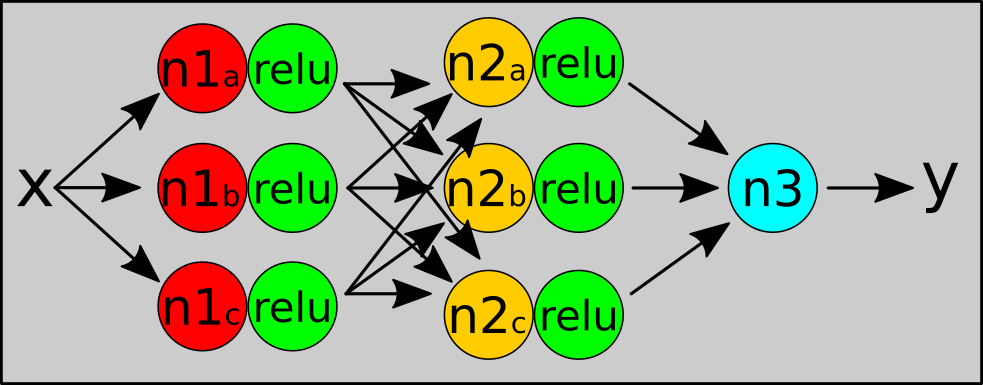

Notice that, now the input layer (red n1) is projecting the data into 3 dimensions. *Each* of the hidden-layer neurons (yellow n2) *maintains* the 3-dimensional data structure. Finally, the output neuron (n3) is doing a linear projection from 3 dimensions to the single output dimension (y).

The *entire* network is basically 'operating' in 3 dimensions.

Let's build this network!

We *only* need to increase the "units" options for *both* the input and hidden layers of our model. Let's decide on trying **8** units for each layer, so our model will operate in 8-dimensional space.

We should then set

    units=8

for both the first and second layers of the network, but keep the output layer having only 1 unit, because the output should stay 1-dimensional (it should have output shape "(None,1)"). Of course, the input shape stays the same!

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=8, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=8, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

The new model has 3 layers and 97 total free parameters. The output shape of the first layer "(None,8)" tells us that this layer 'projects' the data into an 8-dimensional space (the dimension of the last rank of the tensor). The model uses 16 parameters to do this projection: each unit has an input weight (the slope of the line) and a bias term (the y-intercept); there are 8 units with 2 parameters each, so 16 total parameters.

The second layer maintains the 8-dimensional space, as we can see from it's output shape "(None,8)" - the dimension of the last tensor rank is 8.

There are 72 model parameters in the second layer. Let's see... each unit has 8 input weights (it's a linear model in 8 dimensions) plus a *single* bias term, so there are 9 parameters for each unit. There are 8 units... 9*8=72 total parameters in the hidden layer.

The output layer's shape is "(None,1)", which is *required* of our model to output 1-dimensional responses. The majority of neural networks probably have output dimension 1.

The output unit has to 'project' the data back down to 1-dimensional space. It needs 8 weight parameters, one for each of the previous layer's outputs, plus a bias term. So, 9 parameters for the output projection.

Incidentally, the number of parameters in our model is beginning to approach the number training data samples we have... but we'll think about that later.

Let's see if our model has a better fit to the polynomial data.

In [ ]:
model.fit(data, epochs=200)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

It's definitely getting *much closer*, but it's still quite a ways off from a best-fit polynomial.

Notice that we also trained this model for 200 epochs, instead of the 100 we were using for the simpler models? Hmmm...

We could try increasing *either* the depth or the width of the network, to see if it improves the fit. But let's just cut to the chase and increase *both* the depth (add another hidden layer) *and* the width (increase units to 16).

The entire end-to-end product (including data simulation) is reproduced in the code cell below. This one might take a few minutes to run.

In [ ]:
import sklearn.datasets
import matplotlib.pyplot as plt
import tensorflow

# simulate polynomial data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=1,
                                       bias=0.0,
                                       noise=10.0,
                                       random_state=102218)
y = (y/200.0)**2 - 0.5

# build neural network with depth=4, width=16
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

# package data into tensorflow Dataset and fit model
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=500)

# predict response variable and plot model fit
y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

Just by looking at the plot, the fit appears to be getting pretty good. The mean-squared error loss was 0.0011, which was definitely the lowest of any of the model fits I tried. The residuals are relatively small, and there doesn't appear to be any obvious systematic bias.

There could be all kinds of problems with this model from a data-analysis perspective, but it *does* appear that we've approximated a polynomial to a 'reasonable' amount of accuracy 'by eye', using a feed-forward neural network with depth 4 and width 16, with ReLU activations.

In this case, it appears that increasing *both* the depth *and* the width of the network was important for modeling the polynomial function. Although we haven't done a *systematic* assessment to determine if this is *really* the case in general, most neural networks used 'in practice' have significant width and depth.

The width and depth of the network are fundamental 'parameters' that you can use in practice to modify how your model functions. The width essentially defines the dimension of the space your model is working in, whereas the depth controls the complexity of the computation within that dimensional space.

The specific combination of depth and width appropriate for a specific data-analysis problem is likely to vary *a great deal*, depending on the specifics of the problem being studied.

We might think, a little bit, about the number of trainable parameters in our model. If you scroll back (and you have to scroll waaayyy back), the model summary reports that there are 593 parameters in this model. The reason you had to scroll waaayyy back is that it took *additional* epochs of training to fit all those parameters! Did you notice that there were 500 epochs of training in this case?

When I trained the model, it plateaued to a mean-squared error loss of 0.0011, but it didn't reach that value unitl epoch 363! The simpler models had reached obvious convergence to a minimal loss by much fewer than 100 epochs.

In general, as you increase the number of parameters in your model, you will also increase the required training time. Hardware acceleration *definitely* helps with this problem, allowing 'paramter-rich' models to be trained in a 'reasonable' amount of time.

Having a large number of parameters in your model can *also* make your model prone to over-fitting, and for that hardware acceleration will not help.

But we'll worry about over-fitting on another day. For now we'll just bask in the 'glory' of fitting polynomially-distributed data with a neural network.